In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Extra: Inspection for "Date"

from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('station')
print("station")
for column in columns:
    print(column["name"], column["type"])

print()

columns = inspector.get_columns('measurement')
print("measurement")
for column in columns:
    print(column["name"], column["type"])

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

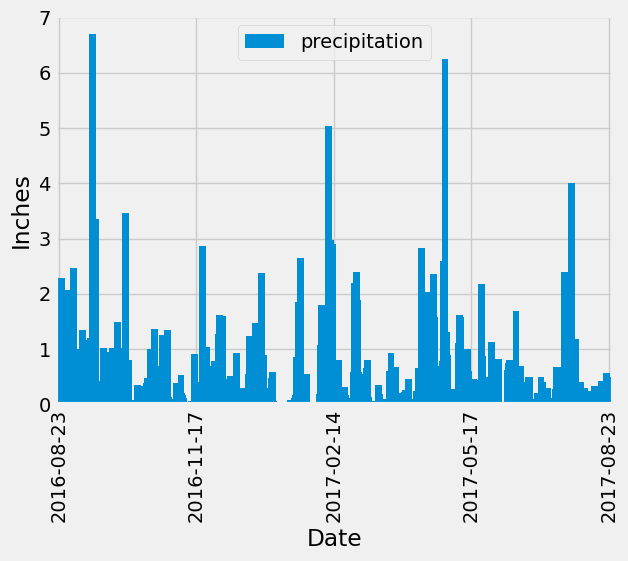

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_before_mrd_dt = most_recent_date_dt - dt.timedelta(days = 365)
one_year_before = dt.datetime.strftime(one_year_before_mrd_dt, '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
# Note: measurement.prcp must not be empty
query_one_year = session.query(measurement.date, measurement.prcp).\
                filter(measurement.date >= one_year_before).\
                filter(measurement.prcp !='').\
                order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_df = pd.DataFrame(query_one_year, columns=['date', 'precipitation'])

# Sort the dataframe by date
results_df = results_df.sort_values(by = 'date')
results_df = results_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data

# set xticks
xticks = [0]
for i in range(1,5):
    xticks.append(int(len(results_df)*i/4-1))

results_df.plot.bar(width=25, xlabel = "Date", ylabel = "Inches")
plt.xticks(xticks)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Simple aggregation code can't be used because .agg don't support the calculation of quartiles
# find out count, mean, std, min, 25%, median, 75%, max

quartiles = results_df["precipitation"].quantile([.25,.5,.75])

lowerq = quartiles[0.25]
upperq = quartiles[0.75]


count = results_df["precipitation"].count()
mean = results_df["precipitation"].mean()
std = results_df["precipitation"].std()
min = results_df["precipitation"].min()
lq = quartiles[0.25]
median = quartiles[0.5]
uq = quartiles[0.75]
max = results_df["precipitation"].max()

# Set dataframe using dictionary
indexes = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
precipitation = [count, mean, std, min, lq, median, uq, max]

prcp_stats = {
            "indexes": indexes,
            "precipitation": precipitation
            }
prcp_stats_df = pd.DataFrame(prcp_stats).set_index("indexes")
prcp_stats_df.index.name = None
prcp_stats_df


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset

# Method 1 (Counting directly from station.station, returns a list) (most preferred)
sel = [func.count(station.station)]
station_count = session.query(*sel).all()
print(station_count)

# Method 2 (Counting distinct values from measurement.station, returns a list)
sel = [func.count(measurement.station.distinct())]
station_count = session.query(*sel).all()
print(station_count)

# Method 3 (Counting from station.station using group_by, returns an integer) (not preferred)
station_count = session.query(station).group_by(station.station).count()
print(station_count)

# Method 4 (Counting values from measurement.station using group_by, returns an integer) (not preferred)
station_count = session.query(measurement).group_by(measurement.station).count()
print(station_count)

[(9,)]
[(9,)]
9
9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

sel = [measurement.station, func.count(measurement.id)]
station_count = session.query(*sel).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.id).desc()).all()
from pprint import pprint
pprint(station_count)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find out the most active station
most_active_station = session.query(measurement.station).\
                                    group_by(measurement.station).\
                                    order_by(func.count(measurement.id).desc()).first()[0]

# make a query
sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
temperature_stats = session.query(*sel).\
                                filter(measurement.station == most_active_station).all()
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


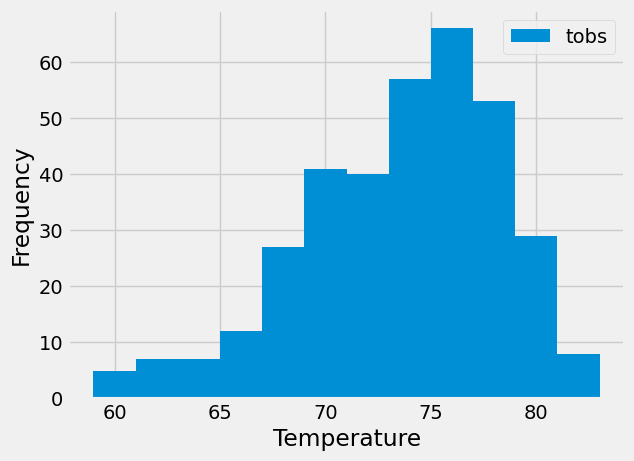

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


### Disabled: repeated code
# most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
# most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# one_year_before_mrd_dt = most_recent_date_dt - dt.timedelta(days = 365)
# one_year_before = dt.datetime.strftime(one_year_before_mrd_dt, '%Y-%m-%d')
### Disabled: repeated code

# Make a query.
# measurement.tobs must not be empty.

temp_mas = session.query(measurement.tobs).\
                        filter(measurement.station == most_active_station).\
                        filter(measurement.date >= one_year_before).\
                        filter(measurement.tobs !='').\
                        order_by(measurement.date.desc()).all()

# convert the query to a list
temp_mas_list = []
for i in temp_mas:
    temp_mas_list.append(i[0])

# plot a histogram
plt.hist(temp_mas_list, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(("tobs",))
plt.show()


# Close Session

In [17]:
# Close Session
session.close()